In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hwk02.ipynb")

In [2]:
# Import all the modules we need
from IPython.core.display import HTML
from datascience import *

import os
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter('ignore', FutureWarning)

## Homework 2: Review of survey results
### Load the survey responses

In [3]:
os.getcwd() # this is a line that tells you the current working directory. It's a helpful move before you want to load something.
            # we are in the folder of hwk2, so we can import the data directly.

'/home/jovyan/demog180-fa2024/hwk/hwk02'

In [4]:
survey = Table.read_table('ucb_fa2024_personal_networks_clean.csv')

How many responses are there?

In [5]:
num_rows = survey.num_rows
num_rows

176

### Who responded to the survey?

Look at the age distribution of respondents:

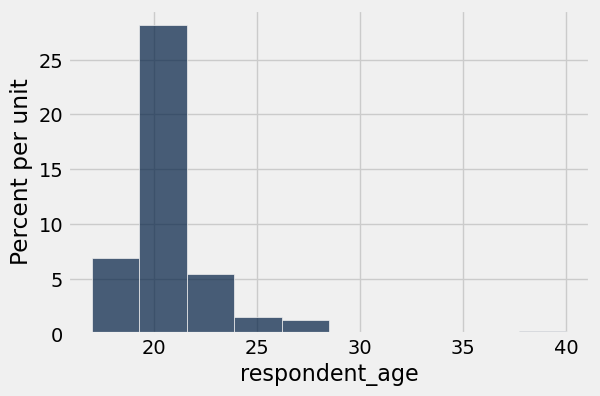

In [6]:
survey.select('respondent_age').hist()

Look at the gender distribution:

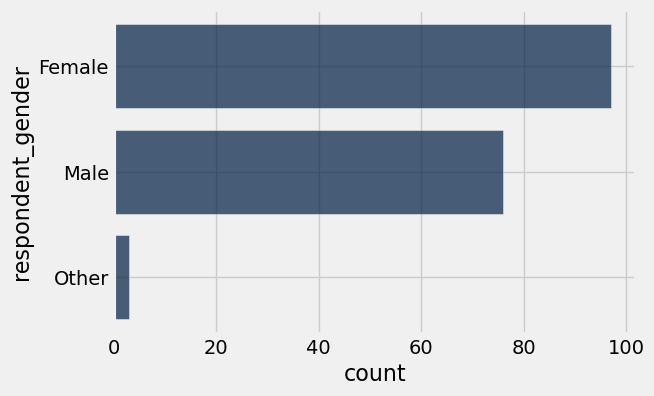

In [7]:
survey.group('respondent_gender').barh('respondent_gender')

Look at the class distribution

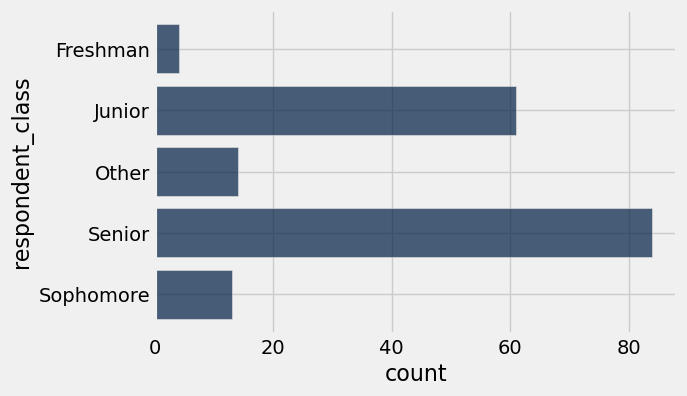

In [8]:
survey.group('respondent_class').barh('respondent_class')

### Relationship between respondent and first alter named: gender

In [9]:
#pd.crosstab(survey['respondent_gender'], survey['alter1_gender']) # this would show raw counts
pd.crosstab(survey['respondent_gender'], survey['alter1_gender'], normalize='index')

col_0,Female,Male,Other,nan
row_0,,,,
Female,0.783505,0.206186,0.010309,0.000000
Male,0.407895,0.526316,0.039474,0.026316
Other,0.333333,0.666667,0.000000,0.000000


In [10]:
pd.crosstab(survey['respondent_gender'], survey['alter1_gender']) # this would show raw counts

col_0,Female,Male,Other,nan
row_0,,,,
Female,76,20,1,0
Male,31,40,3,2
Other,1,2,0,0


In [11]:
obs_frac_nonhom = (23 + 43) / (93 + 23 + 43 + 48)
obs_frac_nonhom

0.3188405797101449

In [12]:
# Berkeley undergrad gender breakdown source: 
# https://opa.berkeley.edu/campus-data/uc-berkeley-quick-facts
# (based on Fall 2022 undergraduate enrollment)
prop_male = 14183 / (14183 + 17808)
prop_female = 1 - prop_male

rand_expected_mf = 2 * prop_male * prop_female
rand_expected_mf

0.49358006849557406

In [13]:
permuted_alter_gender = survey.select('alter1_gender').sample(num_rows) # NB: num_rows is the number of rows in our dataset
permuted_dyads = Table().with_columns(
    'respondent_gender', survey.column('respondent_gender'),
    'alter1_gender', permuted_alter_gender.column(0))
permuted_dyads

respondent_gender,alter1_gender
Female,Male
Male,Female
Female,Male
Male,Male
Female,Male
Female,Female
Male,Female
Male,Male
Male,Female
Male,Male


Let's write a function to help calculate the fraction of dyads that goes from male to female or from female to male.

In [14]:
def frac_mf_dyads(permuted_df):
    """
    Calculate the fraction of dyads that is male to female OR female to male
    """
    counts_mf = permuted_dyads.group(['respondent_gender', 'alter1_gender']).where('respondent_gender', 'Male').where('alter1_gender', 'Female')
    mf = counts_mf.column('count').item(0)
    counts_fm = permuted_dyads.group(['respondent_gender', 'alter1_gender']).where('respondent_gender', 'Female').where('alter1_gender', 'Male')
    fm = counts_fm.column('count').item(0)
    
    return((mf + fm)/permuted_df.num_rows)

#permuted_frac_mf = permuted_dyads.where()
frac_mf_dyads(permuted_dyads)

0.4715909090909091

## Homework 2 (the part you will turn in): Homophily in personal networks

Homophily is a sociological concept that describes the phenomenon of 'like attracts like'. For example, Berkeley students might hang out more with those who are the same gender as themselves, from the same states/cities, takes the same classes, etc. We will discuss homophily in detail in future lectures, but let's explore evidence of homophily in the data that we collected.

First, we need to manipulate the data to facilitate our analysis.

Let's take many resamples and calculate the fraction of cross-gender edges for each one

In [15]:
nonhom_fracs = make_array()

for _ in np.arange(10000):
    permuted_alter_gender = survey.select('alter1_gender').sample(num_rows) # NB: num_rows is the number of rows in our dataset
    permuted_dyads = Table().with_columns(
        'respondent_gender', survey.column('respondent_gender'),
        'alter1_gender', permuted_alter_gender.column(0))
    nonhom_fracs = np.append(nonhom_fracs, frac_mf_dyads(permuted_dyads))
null_fracs = Table().with_column('frac_dyads_nonhom', nonhom_fracs)

Let's add a plot showing where our observed value is, so that we can easily compare the observed value to the null distribution.

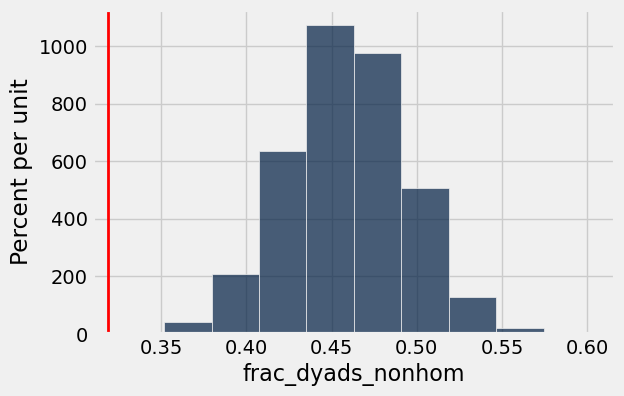

In [18]:
null_fracs.hist('frac_dyads_nonhom')
#plt.scatter(obs_frac_nonhom,0,c='red',s=80);
plt.axvline(x=obs_frac_nonhom,c='red',linewidth=2);

We will convert the table from wide format to long format, like we did in Lab 1, using slightly modified versions of `repeat_single_col` and `wide_to_long`.

In [19]:
def repeat_single_col(data, var_name, times=5):
    """Repeats a single column multiple times.
    
    Parameters
    ----------
    data : Table
        The data table containing the column to be repeated.
    var_name : str
        Text that contains the name of the column to repeat.
    times : int
        The number of times column is to be repeated.
    
    Returns
    -------
    np.array
        A single array with the contents of the column repeated five times.
    
    Examples
    --------
    >>> repeat_single_col(Table().with_columns(['respondent_age', [10]]), 'respondent_age')
    
    array([10, 10, 10, 10, 10])
    """
    new_col = np.tile(data.column(var_name), times)
    return new_col

def wide_to_long(data, var_name, times=5):
    """Given columns of alter characteristics, stack them into one long column.
    
    Parameters
    ----------
    data : Table
        The data table containing the alter characteristics
    var_name : str
        Text that contains the variable name; columns of the dataset should
        match the pattern: alter[NUM]_[var_name]
        For example, if var_name is 'age' then this function expects to find
        columns in the survey dataset named 
        'alter1_age', 'alter2_age', 'alter3_age', 'alter4_age', and 'alter5_age'
    times : int
        The number of columns for each characteristic
    
    Returns
    -------
    np.array
        A single array with the contents of all of the columns stacked on top of one another.
    
    Examples
    --------
    >>> wide_to_long(Table().with_columns(['alter1_age', [10, 15],
                                           'alter2_age', [30, 35],
                                           'alter3_age', [20, 15],
                                           'alter4_age', [60, 70],
                                           'alter5_age', [20, 25]]),
                     'age')
    
    array([10, 15, 30, 35, 20, 15, 60, 70, 20, 25])
    """
    new_col = np.concatenate([data.column('alter' + str(idx) + '_' + var_name) for idx in range(1,times+1)])
    return new_col

Also, create an id variable for our survey respondents

In [20]:
## create a respondent id variable
survey['respondent_id'] = range(1, survey.num_rows + 1) # using [] is a short-hand approach for .with_column function

In [21]:
survey.show(6)

interview_number,interview_date,interview_time,respondent_gender,respondent_age,respondent_class,respondent_home,number_alters,alter1_gender,alter1_age,alter1_class,alter1_home,alter1_howclose,alter1_howoften,alter2_gender,alter2_age,alter2_class,alter2_home,alter2_howclose,alter2_howoften,alter3_gender,alter3_age,alter3_class,alter3_home,alter3_howclose,alter3_howoften,alter4_gender,alter4_age,alter4_class,alter4_home,alter4_howclose,alter4_howoften,alter5_gender,alter5_age,alter5_class,alter5_home,alter5_howclose,alter5_howoften,respondent_id
1,8/29/2024,14:24:00,Female,26,Other,Bay Area,5,Male,56,Other,Bay Area,Close friend,Once a week,Female,55,Other,Bay Area,Close friend,Once a week,Female,28,Other,Bay Area,Close friend,Once a week,Female,26,Other,Rest of World,Close friend,Once a month,Female,27,Other,Rest of World,Close friend,Once a week,1
2,8/29/2024,14:55:00,Male,24,Other,Rest of United States,5,Male,24,Other,Rest of United States,Close friend,More than once a week,Female,24,Other,Rest of United States,Close friend,Once a month,Female,55,Other,Rest of World,Close friend,More than once a week,Female,24,Other,Rest of United States,Friend,Once a month,Female,24,Other,Rest of United States,Close friend,Once a week,2
1,8/29/2024,14:30:00,Female,20,Junior,Bay Area,6+,Female,51,Other,Rest of World,Close friend,More than once a week,Male,54,Other,Rest of World,Close friend,More than once a week,Female,20,Junior,Bay Area,Close friend,More than once a week,Female,20,Junior,Rest of United States,Close friend,More than once a week,Female,26,Other,Rest of World,Close friend,More than once a week,3
3,8/30/2024,10:21:00,Male,24,Other,Rest of United States,5,Other,24,Other,LA Area,Close friend,More than once a week,Other,24,Other,Rest of United States,Close friend,More than once a week,Female,24,Other,Rest of United States,Close friend,More than once a week,Female,25,Other,Rest of United States,Friend,More than once a week,Female,58,Other,Rest of United States,Close friend,More than once a week,4
1,8/30/2024,15:31:00,Female,22,Other,LA Area,4,Female,21,Senior,Rest of California,Close friend,More than once a week,Female,21,Senior,Rest of California,Close friend,More than once a week,Male,21,Junior,Rest of United States,Close friend,More than once a week,Female,20,Senior,Bay Area,Close friend,Once a week,nan,nan,nan,nan,nan,nan,5
1,8/31/2024,16:32:00,Female,21,Senior,LA Area,5,Female,60,Other,LA Area,Close friend,More than once a week,Male,21,Senior,LA Area,Close friend,More than once a week,Female,20,Junior,LA Area,Close friend,Once a month,Female,30,Other,LA Area,Close friend,Once a month,Male,21,Senior,LA Area,Close friend,Once a week,6


## Question 1: Full Alters Table

Create a long dataset that has

* respondent id
* respondent age
* respondent class
* respondent home
* alter age
* alter gender
* alter class
* alter home

Don't forget to perform a couple of checks to be sure the resulting dataset makes sense (like we did in Lab 1).

*Hint: you need to **repeat** the information for the respondent and **convert from wide to long** for the alters' information.*

In [22]:

alter_data = Table().with_columns([
    'respondent_id', repeat_single_col(survey, 'respondent_id'),
    'respondent_age', repeat_single_col(survey, 'respondent_age'),
    'respondent_class', repeat_single_col(survey, 'respondent_class'),
    'respondent_home', repeat_single_col(survey, 'respondent_home'),
    'alter_age', wide_to_long(survey, 'age'),
    'alter_gender', wide_to_long(survey, 'gender'),
    'alter_class', wide_to_long(survey, 'class'),
    'alter_home', wide_to_long(survey, 'home')])

alter_data

respondent_id,respondent_age,respondent_class,respondent_home,alter_age,alter_gender,alter_class,alter_home
1,26,Other,Bay Area,56,Male,Other,Bay Area
2,24,Other,Rest of United States,24,Male,Other,Rest of United States
3,20,Junior,Bay Area,51,Female,Other,Rest of World
4,24,Other,Rest of United States,24,Other,Other,LA Area
5,22,Other,LA Area,21,Female,Senior,Rest of California
6,21,Senior,LA Area,60,Female,Other,LA Area
7,21,Senior,LA Area,21,Male,Senior,LA Area
8,23,Senior,Rest of World,50,Female,Other,Rest of World
9,20,Junior,Rest of World,55,Male,Other,Rest of World
10,19,Junior,Rest of World,50,Female,Other,Rest of World


In [23]:
grader.check("q1")

q1 results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 2: Ages of Berkeley Students' Confidants

OK, now that we have created a long-form dataset, let's make use of it to learn about the people Berkeley students discuss important matters with.

Start by making a histogram of the confidants' ages. Please use the following value for the parameter `bins`: `np.arange(15, 70, 5)`

*Hint: you can look up the documentation of the `Table.hist()` function*

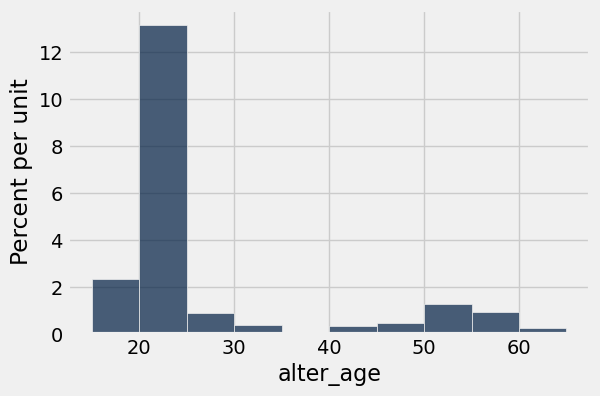

In [25]:
alter_data.hist("alter_age", bins=np.arange(15, 70, 5))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 3: Respondent's Ages
Now make a histogram of the survey respondents' ages.

Use the following value for the parameter `bins`: `np.arange(15, 35, 1)`. You can try and see what happens if you remove this and plot with the line of code we used for alter's age. <BR>

*Hint: Make sure you use the `survey` table, not the `alter_data` table.*

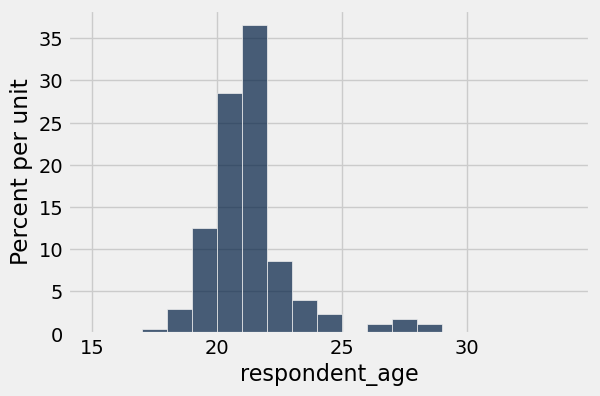

In [26]:
alter_data.hist("respondent_age", bins=np.arange(15, 35, 1))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 4: Comapre histograms
Compare the two histograms. What does this tell you about homophily among confidants?

_The survey respondents appear to be much younger than the confidants. You could take this to mean that people look towards older/more experienced people for advice on important matters, which I think is partly true. I think the bigger takeaway, which can not be confirmed simply by the age but intuitively makes sense, is that many of the survey respondents (us, the students), look to their **parents** for advice on important matters, and they tend to fall into the 45-60 range as shown in the first histogram._

<!-- END QUESTION -->

Now you can make a scatter plot comparing the ages of survey respondents and the ages of the alters.

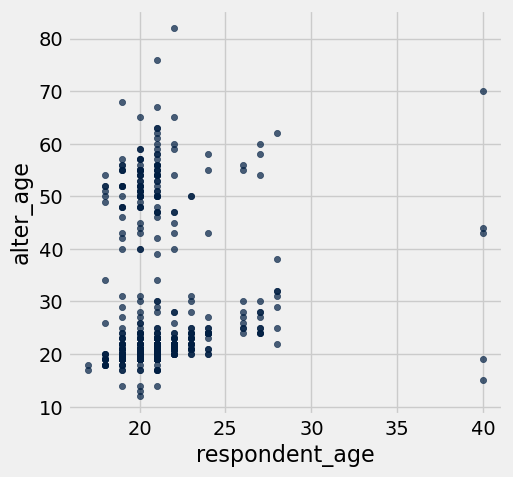

In [27]:
alter_data.scatter('respondent_age', 'alter_age')

<!-- BEGIN QUESTION -->

## Question 5
What does this scatter plot tell you about homophily among confidants?

_The above scatterplot shows a strong clustering of confidants and respondents around equal ages. For example, 20 year old respondents tend to list most of their alter's with ages between 20-28. Similar things can be said for 19 year old respondents and 21 year old respondents. It is an interesting visualization of the secondary cluster, the one around age 50 which I believe represents the respondent's parents._

<!-- END QUESTION -->

We are able to get a lot of descriptive information from these two datasets. Here is a practice example.

**Practice** What's the proportion of alters from Bay Area of all the alters?

In [29]:
# First, you create a variable, alter_bay which has value False if the alter is not from the Bay Area, 
# and True otherwise.
alter_bay = alter_data.column("respondent_home") == 'Bay Area' # two equal marks == constructs a comparison, the result is True (equal to) or False (not equalt to)

In [31]:
# Second, you calculate the proportion of the rows which has the alter_bay variable True.
alter_bay_proportion = np.count_nonzero(alter_bay) / len(alter_bay)
alter_bay_proportion

0.39204545454545453

### Class year of Berkeley students' confidants

In this section, we will start to explore the relationship between respondents' class years and their alters' class years. Our approach will be to walk through one example -- the alters reported by sophomores -- in detail. Then, we will write a function to easily allow us to repeat our analysis for sophomores, juniors, and seniors.

First, let us look at the distribution of class year among all of the confidants reported. First use `group` to make a simple table with the counts of alters by class year.

In [32]:
alter_data.group('alter_class')

alter_class,count
Freshman,10
Junior,187
Other,282
Senior,243
Sophomore,60
nan,98


Now you can make a bar plot that shows those counts graphically.

In [33]:
# First we sort this table by counts of each group
alter_data.group('alter_class').sort('count', descending=True)

alter_class,count
Other,282
Senior,243
Junior,187
nan,98
Sophomore,60
Freshman,10


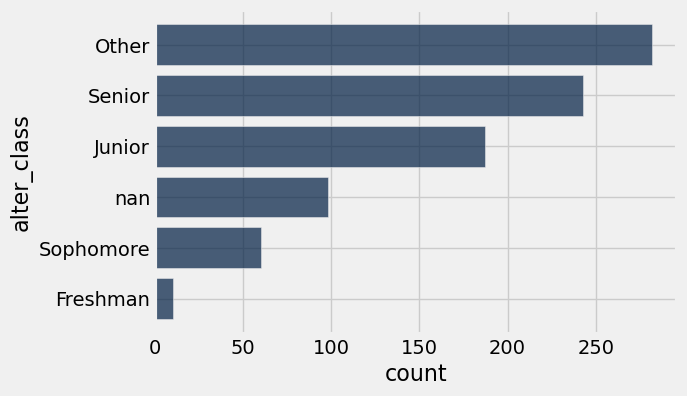

In [34]:
# By adding the function of plotting: .barh(the variable you want to plot), we can create a bar plot.
alter_data.group('alter_class').sort('count', descending=True).barh('alter_class')

Make another bar plot that shows the class years of survey respondents.

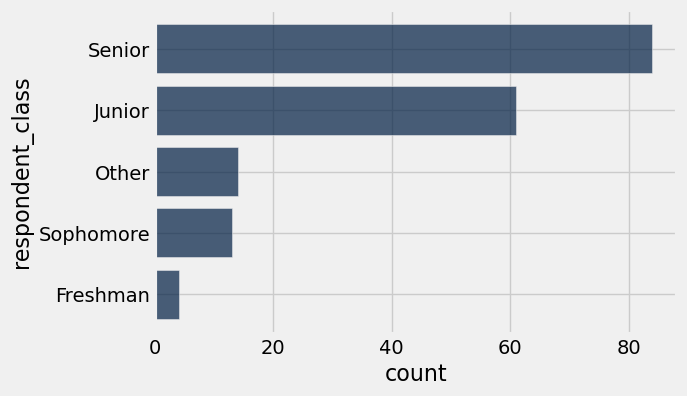

In [35]:
survey.group('respondent_class').sort('count', descending=True).barh('respondent_class')

Now that we have a sense of what all respondents and all of the alters look like, we can dig into the alters of a particulr class group.

## Question 6: 
Create a new table that only has alters reported by respondents who are sophomores using `where` and `are.equal_to`.

In [42]:
alter_data

respondent_id,respondent_age,respondent_class,respondent_home,alter_age,alter_gender,alter_class,alter_home
1,26,Other,Bay Area,56,Male,Other,Bay Area
2,24,Other,Rest of United States,24,Male,Other,Rest of United States
3,20,Junior,Bay Area,51,Female,Other,Rest of World
4,24,Other,Rest of United States,24,Other,Other,LA Area
5,22,Other,LA Area,21,Female,Senior,Rest of California
6,21,Senior,LA Area,60,Female,Other,LA Area
7,21,Senior,LA Area,21,Male,Senior,LA Area
8,23,Senior,Rest of World,50,Female,Other,Rest of World
9,20,Junior,Rest of World,55,Male,Other,Rest of World
10,19,Junior,Rest of World,50,Female,Other,Rest of World


In [43]:
alters_of_sophomores = alter_data.where("respondent_class", are.equal_to("Sophomore"))
q6 = alters_of_sophomores.num_rows
q6

65

In [44]:
grader.check("q6")

q6 results: All test cases passed!

Make a plot that shows the class years reported by alters of sophomores using .barh().

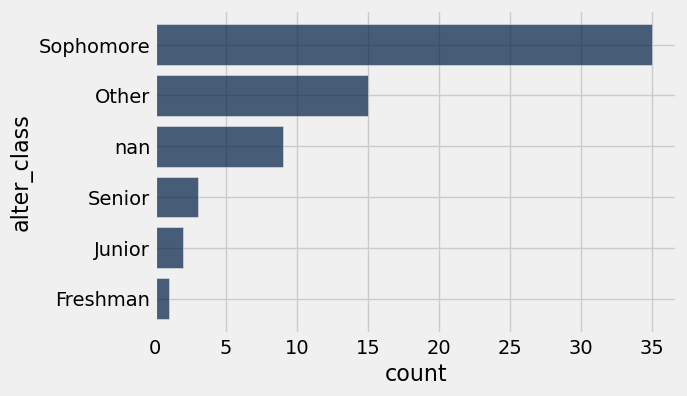

In [45]:
alters_of_sophomores.group('alter_class').sort('count', descending=True).barh('alter_class')

Let's make a function called `plot_alter_class` that makes a plot of the class years of alters reported by respondents in a particular class. Your function should take as its arguments

* `data` - the alter dataset
* `class_year` - the class year of respondents to focus on
    
For example, running

    plot_alter_class(alter_data, 'Sophomore')

should produce the plot you just made above.

In [46]:
def plot_alter_class(data, class_year):
    to_plot = data.where('alter_class', class_year) #create the dataset for plotting
    to_plot.group('respondent_class').barh('respondent_class')

Use `plot_alter_class` function to produce plots of the class years of the alters of freshmen, sophomores, juniors, and seniors.

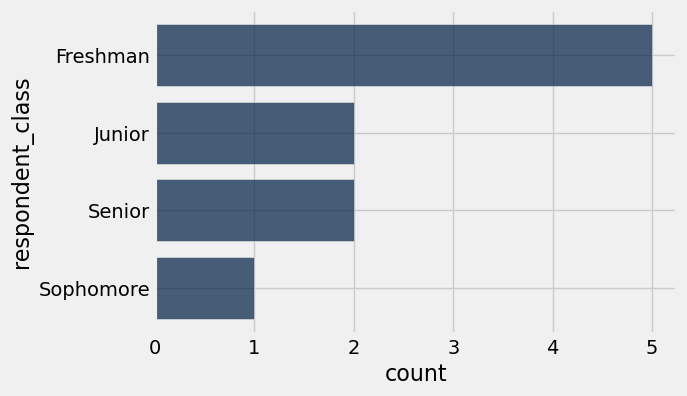

In [47]:
# freshmen
plot_alter_class(alter_data, 'Freshman')

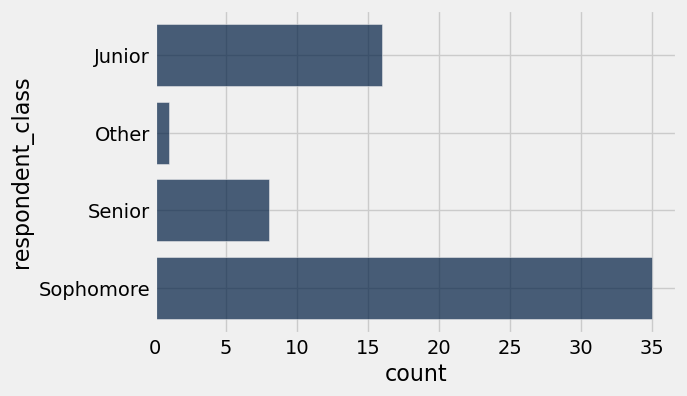

In [48]:
# sophomores
plot_alter_class(alter_data, 'Sophomore')

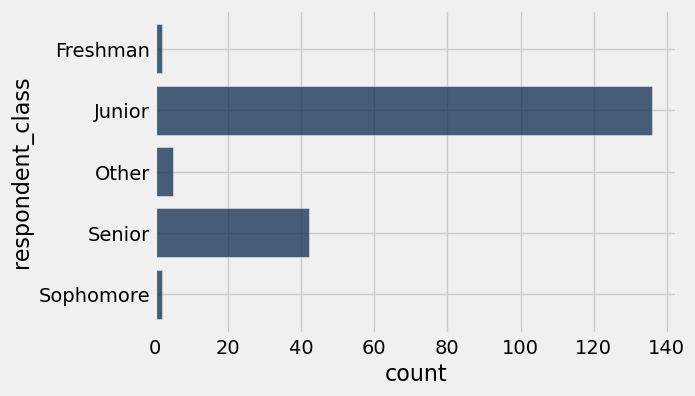

In [49]:
# juniors
plot_alter_class(alter_data, 'Junior')

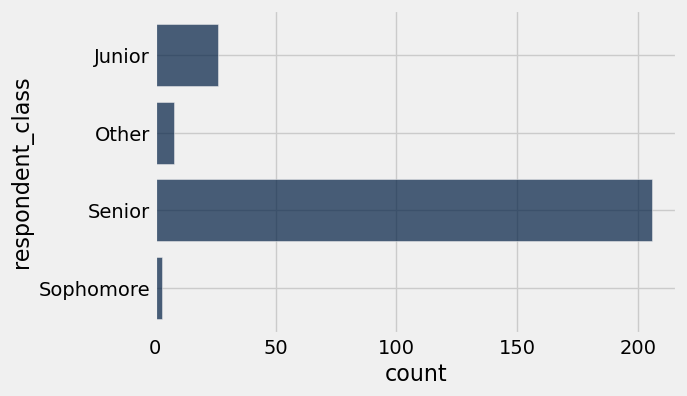

In [50]:
# seniors
plot_alter_class(alter_data, 'Senior')

<!-- BEGIN QUESTION -->

## Question 7
Do you see evidence of homophily with respect to class year?

_There is pretty clear evidence of homophily with respect to class year. More interestingly (is that a word?), hompohily seems to become much stronger as class year increases._

<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [51]:
grader.check_all()

q1 results: All test cases passed!

q6 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Please upload the .zip file to Gradescope.

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

Running your submission against local test cases...

